In [1]:
import os
import glob
import cv2
import math
import itertools

import numpy as np
from datetime import datetime
import tensorflow as tf
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix

from keras import backend
from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, Input
from keras.optimizers import SGD
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.utils.data_utils import get_file
from keras import metrics

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
class DriverDistractionHelper:
    
    def __init__(self, img_rows, img_cols, color_type=1):
        x_train, y_train, driver_id, unique_drivers = self.read_and_normalize_train_data(img_rows, img_cols, color_type)
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=4484, random_state=57, stratify=y_train)
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=4484, random_state=57, stratify=y_train)
        
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.x_val = x_val
        self.y_val = y_val
            
    def read_and_normalize_train_data(self, img_rows, img_cols, color_type):
        cache_path = os.path.join('cache', 'train_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
        if not os.path.isfile(cache_path) or use_cache == 0:
            x_train, y_train, driver_id, unique_drivers = self.load_train(img_rows, img_cols, color_type)
            self.cache_data((x_train, y_train, driver_id, unique_drivers), cache_path)
        else:
            print('Restore train from cache!')
            (x_train, train_target, driver_id, unique_drivers) = restore_data(cache_path)

        x_train = np.array(x_train, dtype=np.uint8)
        y_train = np.array(y_train, dtype=np.uint8)
        x_train = x_train.reshape(x_train.shape[0], color_type, img_rows, img_cols)
        y_train = np_utils.to_categorical(y_train, 10)
        x_train = x_train.astype('float32')
        x_train /= 255
        print('Train shape:', x_train.shape)
        print(x_train.shape[0], 'train samples')
        return x_train, y_train, driver_id, unique_drivers
    
    def read_and_normalize_test_data(self, begin_index, img_rows, img_cols, color_type=1, count=1000):
        cache_path = os.path.join('cache', 'test_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
        if not os.path.isfile(cache_path) or use_cache == 0:
            test_data, test_ids = self.load_test(begin_index, img_rows, img_cols, color_type, count)
            self.cache_data((test_data), cache_path)
        else:
            print('Restore test from cache!')
            (test_data, test_id) = restore_data(cache_path)

        test_data = np.array(test_data, dtype=np.uint8)
        test_data = test_data.reshape(test_data.shape[0], color_type, img_rows, img_cols)
        test_data = test_data.astype('float32')
        test_data /= 255
        print('Test shape:', test_data.shape)
        print(test_data.shape[0], 'test samples')
        return test_data, test_ids
    
    def load_train(self, img_rows, img_cols, color_type=1):
        X_train = []
        y_train = []
        driver_id = []

        driver_data = self.get_driver_data()

        print('Read train images')
        for j in range(10):
            print('Load folder c{}'.format(j))
            path = os.path.join('..', '..', 'input', 'train', 'c' + str(j), '*.jpg')
            files = glob.glob(path)
            for fl in files:
                flbase = os.path.basename(fl)
                img = self.get_image(fl, img_rows, img_cols, color_type)
                X_train.append(img)
                y_train.append(j)
                driver_id.append(driver_data[flbase])

        unique_drivers = sorted(list(set(driver_id)))
        print('Unique drivers: {}'.format(len(unique_drivers)))
        print(unique_drivers)
        return X_train, y_train, driver_id, unique_drivers
    
    def load_test(self, begin_index, img_rows, img_cols, color_type=1, count=1000):
        print('Read manual test images')
        path = os.path.join('..', '..', 'input', 'test', '*.jpg')
        files = sorted(glob.glob(path))
        
        if(len(files)-count < begin_index):
            files = files[begin_index : len(files)]
        else:
            files = files[begin_index : begin_index+count]

        X_test = []
        X_test_id = []
        total = 0
        for fl in files:
            flbase = os.path.basename(fl)
            img = self.get_image(fl, img_rows, img_cols, color_type)
            X_test.append(img)
            X_test_id.append(flbase)
            total += 1
        return X_test, X_test_id
    
    def cache_data(self, data, path):
        if os.path.isdir(os.path.dirname(path)):
            file = open(path, 'wb')
            pickle.dump(data, file)
            file.close()
        else:
            print('Directory doesnt exists')
    
    def get_driver_data(self):
        dr = dict()
        path = os.path.join('..', '..', 'input', 'driver_imgs_list.csv')
        print('Read drivers data')
        f = open(path, 'r')
        line = f.readline()
        while (1):
            line = f.readline()
            if line == '':
                break
            arr = line.strip().split(',')
            dr[arr[2]] = arr[0]
        f.close()
        return dr
    
    def get_image(self, path, img_rows, img_cols, color_type=1):
        # Load as grayscale
        if color_type == 1:
            img = cv2.imread(path, 0)
        elif color_type == 3:
            img = cv2.imread(path)
        return cv2.resize(img, (img_cols, img_rows))

In [3]:
def create_model(img_rows, img_cols, color_type=1):
    nb_classes = 10
    # number of convolutional filters to use
    nb_filters = 10
    # size of pooling area for max pooling
    nb_pool = 2
    # convolution kernel size
    nb_conv = 2
    model = Sequential()
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv), padding='valid', input_shape=(color_type, img_rows, img_cols), data_format = 'channels_first' ))
    model.add(Activation('relu'))
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool), data_format="channels_first"))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    sgd = SGD(lr=0.1, decay=0, momentum=0, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [4]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
img_rows = 48
img_cols = 64
color_type = 1

batch_size = 32
nb_epoch = 7
random_state = 51

In [10]:
ddh = DriverDistractionHelper(img_rows, img_cols, color_type)

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Directory doesnt exists
('Train shape:', (22424, 1, 48, 64))
(22424, 'train samples')


In [12]:
model = create_model(img_rows, img_cols, color_type)

In [13]:
time_before_training = datetime.now()
for i in range(5):
    model.fit(ddh.x_train, ddh.y_train, batch_size=batch_size, epochs=1, validation_data=(ddh.x_val, ddh.y_val), verbose=1)
time_after_training = datetime.now()

Train on 13456 samples, validate on 4484 samples
Epoch 1/1
13456/13456 [==============================] - 58s 4ms/step - loss: 1.9989 - acc: 0.2575 - val_loss: 1.6245 - val_acc: 0.4050
Train on 13456 samples, validate on 4484 samples
Epoch 1/1
13456/13456 [==============================] - 61s 5ms/step - loss: 1.3030 - acc: 0.5369 - val_loss: 1.1204 - val_acc: 0.6075
Train on 13456 samples, validate on 4484 samples
Epoch 1/1
13456/13456 [==============================] - 60s 4ms/step - loss: 0.8917 - acc: 0.6978 - val_loss: 0.5130 - val_acc: 0.8557
Train on 13456 samples, validate on 4484 samples
Epoch 1/1
13456/13456 [==============================] - 62s 5ms/step - loss: 0.6895 - acc: 0.7676 - val_loss: 0.3825 - val_acc: 0.8932
Train on 13456 samples, validate on 4484 samples
Epoch 1/1
13456/13456 [==============================] - 67s 5ms/step - loss: 0.5647 - acc: 0.8111 - val_loss: 0.2520 - val_acc: 0.9318


In [13]:
time_before_pred = datetime.now()
predictions_valid = model.predict(ddh.x_test, batch_size=128, verbose=1)
time_after_pred = datetime.now()

7400/7400 [==============================] - 20s 3ms/step


In [14]:
training_time = time_after_training - time_before_training
training_time = training_time.total_seconds()

In [15]:
pred_time = time_after_pred - time_before_pred
pred_time_avg = (pred_time.total_seconds()*1000)/len(ddh.x_test)

In [16]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    pure_y_valid = backend.argmax(ddh.y_test)
    pure_y_pred = backend.argmax(predictions_valid)

    
    pure_y_valid = sess.run(pure_y_valid)
    pure_y_pred = sess.run(pure_y_pred)

In [17]:
y_comp = [1 if i==j else 0 for i,j in zip(pure_y_pred, pure_y_valid)]
accuracy = np.mean(y_comp)

In [18]:
score = log_loss(ddh.y_test, predictions_valid)

In [19]:
print 'Accuracy: ', accuracy
print 'Training Time: ', training_time
print 'Average Time to Classify a Image: ', pred_time_avg
print 'Loss: ', score

Accuracy:  0.8116216216216217
Training Time:  533.722555
Average Time to Classify a Image:  2.67988756757
Loss:  0.8204898256323665


In [20]:
cm = confusion_matrix(pure_y_valid, pure_y_pred)

In [21]:
classes = ['safe driving', 'texting - right', 'talking on the phone - right', 'exting - left', 'talking on the phone - left',
          'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger']
keys = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

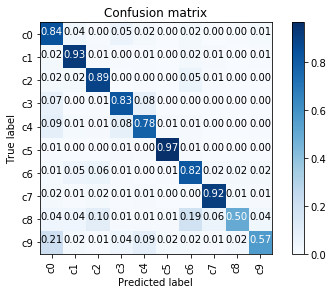

In [23]:
plot_confusion_matrix(cm, keys, normalize=True)

In [24]:
def test_model_and_generate_submission(model, driver_distraction_helper, img_rows, img_cols, color_type):
    test_imgs, test_ids = driver_distraction_helper.read_and_normalize_test_data(0, img_rows, img_cols, color_type, 1000)

    predictions = model.predict(test_imgs, batch_size=128, verbose=1)
    
    general_result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    general_result.loc[:, 'img'] = pd.Series(test_ids, index=general_result.index)
    
    for i in range(80):
        test_imgs, test_ids = driver_distraction_helper.read_and_normalize_test_data(((i+1)*1000), img_rows, img_cols, color_type)

        predictions = model.predict(test_imgs, batch_size=128, verbose=1)
        
        result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
        result.loc[:, 'img'] = pd.Series(test_ids, index=result.index)
        
        general_result = general_result.append(result, ignore_index=True)
        
    now = datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = '_at_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    general_result.to_csv(sub_file, index=False, float_format='%.7f')  

In [25]:
test_model_and_generate_submission(model, ddh, img_rows, img_cols, color_type)

Read manual test images
Directory doesnt exists
('Test shape:', (1000, 3, 48, 64))
(1000, 'test samples')
1000/1000 [==============================] - 3s 3ms/step
Read manual test images
Directory doesnt exists
('Test shape:', (1000, 3, 48, 64))
(1000, 'test samples')
1000/1000 [==============================] - 3s 3ms/step
Read manual test images
Directory doesnt exists
('Test shape:', (1000, 3, 48, 64))
(1000, 'test samples')
1000/1000 [==============================] - 3s 3ms/step
Read manual test images
Directory doesnt exists
('Test shape:', (1000, 3, 48, 64))
(1000, 'test samples')
1000/1000 [==============================] - 3s 3ms/step
Read manual test images
Directory doesnt exists
('Test shape:', (1000, 3, 48, 64))
(1000, 'test samples')
1000/1000 [==============================] - 3s 3ms/step
Read manual test images
Directory doesnt exists
('Test shape:', (1000, 3, 48, 64))
(1000, 'test samples')
1000/1000 [==============================] - 3s 3ms/step
Read manual test image

1000/1000 [==============================] - 2s 2ms/step
Read manual test images
Directory doesnt exists
('Test shape:', (1000, 3, 48, 64))
(1000, 'test samples')
1000/1000 [==============================] - 2s 2ms/step
Read manual test images
Directory doesnt exists
('Test shape:', (1000, 3, 48, 64))
(1000, 'test samples')
1000/1000 [==============================] - 2s 2ms/step
Read manual test images
Directory doesnt exists
('Test shape:', (1000, 3, 48, 64))
(1000, 'test samples')
1000/1000 [==============================] - 2s 2ms/step
Read manual test images
Directory doesnt exists
('Test shape:', (1000, 3, 48, 64))
(1000, 'test samples')
1000/1000 [==============================] - 2s 2ms/step
Read manual test images
Directory doesnt exists
('Test shape:', (1000, 3, 48, 64))
(1000, 'test samples')
1000/1000 [==============================] - 2s 2ms/step
Read manual test images
Directory doesnt exists
('Test shape:', (1000, 3, 48, 64))
(1000, 'test samples')
1000/1000 [===========

In [21]:
#model.save('simple_cnn.h5')

In [ ]:
#for i in range(100):
#    img_brute = ddh.x_manual_tests[i]
#    img = img_brute.transpose(1, 2, 0)
#    img = cv2.resize(img, (img_cols, img_rows))
#    img = img.reshape(1, 1, img_rows, img_cols)
#    predicted = model.predict_classes(img)
        
#    plt.figure()
#    plt.title(predicted)
#    plt.imshow(img_brute.reshape(120, 160), cmap='gray')